# Gaze Pattern Analysis and LSTM Autoencoder Modeling

This notebook analyzes gaze patterns from the OneStop dataset and builds an LSTM autoencoder to learn representations of reading behavior.

## 1. Setup and Data Loading

In [ ]:
!pip install pymovements
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.2/316.2 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 418.3/418.3 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 88.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
  Attempting uninstall: cryptography
    Found existing installation: cryptography 3.4.8
    Uninstalling cryptography-3.4.8:
      Successfully uninstalled cryptography-3.4.8
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pymovements as pm
dataset = pm.Dataset('OneStop', path='data/OneStop')

dataset.download()

fixations_Paragraph.csv.zip: 0.00B [00:00, ?B/s]

Checking integrity of fixations_Paragraph.csv.zip


ia_Paragraph.csv.zip: 0.00B [00:00, ?B/s]

Checking integrity of ia_Paragraph.csv.zip
Extracting fixations_Paragraph.csv.zip to data/OneStop/precomputed_events


100%|██████████| 1/1 [00:51<00:00, 51.86s/it]


Extracting ia_Paragraph.csv.zip to data/OneStop/precomputed_reading_measures


100%|██████████| 1/1 [00:53<00:00, 53.55s/it]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from math import atan2, degrees, isnan, sqrt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


## 2. Data Download and Initial Loading

In [ ]:
# --- Configuration ---
# Set a more professional and publication-ready style for plots
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (12, 7)

# --- Load and Prepare the Data ---
print("Loading data... this might take a moment.")
try:
    # Using low_memory=False can help with mixed data types in large files.
    df = pd.read_csv('/content/data/OneStop/precomputed_events/fixations_Paragraph.csv', low_memory=False)
    print("Data loaded successfully.")
    print(f"Shape: {df.shape}")
    print(f"\nFirst few column names: {list(df.columns[:10])}")
except Exception as e:
    print(f"Error loading data: {e}")

# Quick verification of key columns
key_columns = ['CURRENT_FIX_DURATION', 'NEXT_SAC_AMPLITUDE', 'participant_id',
               'TRIAL_INDEX', 'word_length', 'wordfreq_frequency', 'difficulty_level',
               'CURRENT_FIX_INTEREST_AREA_ID', 'CURRENT_FIX_INTEREST_AREA_LABEL',
               'CURRENT_FIX_X', 'CURRENT_FIX_Y', 'CURRENT_FIX_INDEX']

print("\n--- Checking key columns ---")
for col in key_columns:
    if col in df.columns:
        print(f"✓ {col}")
    else:
        print(f"✗ {col} - MISSING!")

Loading data... this might take a moment.
Data loaded successfully.
Shape: (2400788, 290)

First few column names: ['participant_id', 'TRIAL_INDEX', 'CURRENT_FIX_ADJUSTED', 'CURRENT_FIX_BLINK_AROUND', 'CURRENT_FIX_BUTTON_0_PRESS', 'CURRENT_FIX_BUTTON_1_PRESS', 'CURRENT_FIX_BUTTON_2_PRESS', 'CURRENT_FIX_BUTTON_3_PRESS', 'CURRENT_FIX_BUTTON_4_PRESS', 'CURRENT_FIX_BUTTON_5_PRESS']

--- Checking key columns ---
✓ CURRENT_FIX_DURATION
✓ NEXT_SAC_AMPLITUDE
✓ participant_id
✓ TRIAL_INDEX
✓ word_length
✓ wordfreq_frequency
✓ difficulty_level
✓ CURRENT_FIX_INTEREST_AREA_ID
✓ CURRENT_FIX_INTEREST_AREA_LABEL
✓ CURRENT_FIX_X
✓ CURRENT_FIX_Y
✓ CURRENT_FIX_INDEX


## 3. Initial Data Analysis (Descriptive & Inferential)

In [ ]:
def plot_scanpath(df, participant_id, trial_index):
    """
    Visualizes the scanpath for a single trial of a single participant.
    """
    trial_data = df[(df['participant_id'] == participant_id) & (df['TRIAL_INDEX'] == trial_index)]

    if trial_data.empty:
        print(f"No data found for participant {participant_id}, trial {trial_index}")
        return

    # Sort fixations in chronological order
    trial_data = trial_data.sort_values(by='CURRENT_FIX_INDEX')

    x = trial_data['CURRENT_FIX_X']
    y = trial_data['CURRENT_FIX_Y']
    duration = trial_data['CURRENT_FIX_DURATION']

    plt.figure(figsize=(16, 8))

    # Plot the saccades (lines connecting fixations)
    plt.plot(x, y, marker='', linestyle='-', color='gray', alpha=0.6)

    # Plot the fixations (circles sized by duration)
    scatter = plt.scatter(x, y, s=duration, c=np.arange(len(duration)), cmap='viridis', alpha=0.7, edgecolors='black')

    # Add text labels for the first few fixations to show the reading order
    for i in range(min(15, len(trial_data))):
        plt.text(x.iloc[i], y.iloc[i], str(i+1), ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    plt.title(f'Scanpath for Participant: {participant_id}, Trial: {trial_index}')
    plt.xlabel('X Coordinate (pixels)')
    plt.ylabel('Y Coordinate (pixels)')

    # Invert y-axis as screen coordinates typically start from top-left
    plt.gca().invert_yaxis()
    plt.axis('equal')

    # Add a colorbar to show the time progression
    cbar = plt.colorbar(scatter, label='Fixation Sequence Order')

    plt.savefig(f"scanpath_{participant_id}_trial_{trial_index}.png")
    print(f"Saved plot: scanpath_{participant_id}_trial_{trial_index}.png")
    plt.close()


def perform_analysis(df):
    """
    Run all analyses on the loaded dataframe.
    """
    # --- 2. Descriptive Analysis: Understanding the Basics ---
    print("\n--- Running Descriptive Analysis ---")

    # Plotting the distribution of fixation durations
    plt.figure()
    sns.histplot(df['CURRENT_FIX_DURATION'], kde=True, bins=100, stat="density")
    plt.title('Distribution of Fixation Durations')
    plt.xlabel('Duration (ms)')
    plt.ylabel('Density')
    plt.xlim(0, 1000)
    plt.axvline(df['CURRENT_FIX_DURATION'].median(), color='red', linestyle='--', label=f"Median: {df['CURRENT_FIX_DURATION'].median():.0f} ms")
    plt.legend()
    plt.savefig("fixation_duration_distribution.png")
    print("Saved plot: fixation_duration_distribution.png")
    plt.close()

    # Plotting the distribution of saccade amplitudes
    plt.figure()
    # Convert 'NEXT_SAC_AMPLITUDE' to numeric, coercing errors, before filtering
    df['NEXT_SAC_AMPLITUDE'] = pd.to_numeric(df['NEXT_SAC_AMPLITUDE'], errors='coerce')
    valid_saccades = df['NEXT_SAC_AMPLITUDE'].dropna().loc[df['NEXT_SAC_AMPLITUDE'] > 0]
    sns.histplot(valid_saccades, kde=True, bins=100)
    plt.title('Distribution of Saccade Amplitudes')
    plt.xlabel('Amplitude (degrees of visual angle)')
    plt.ylabel('Count')
    plt.xlim(0, 20)
    plt.axvline(valid_saccades.median(), color='red', linestyle='--', label=f"Median: {valid_saccades.median():.2f} degrees")
    plt.legend()
    plt.savefig("saccade_amplitude_distribution.png")
    print("Saved plot: saccade_amplitude_distribution.png")
    plt.close()

    # --- 3. Scanpath Visualization ---
    print("\n--- Generating a Scanpath Visualization ---")
    example_participant = df['participant_id'].iloc[0]
    example_trial = df['TRIAL_INDEX'].iloc[0]
    plot_scanpath(df, example_participant, example_trial)

    # --- 4. Inferential Analysis: Testing Hypotheses ---
    print("\n--- Running Inferential Analysis ---")

    # Aggregate fixation data to word level
    word_level_df = df.groupby(['participant_id', 'TRIAL_INDEX', 'CURRENT_FIX_INTEREST_AREA_ID', 'CURRENT_FIX_INTEREST_AREA_LABEL']).agg(
        total_fixation_duration=('CURRENT_FIX_DURATION', 'sum'),
        fixation_count=('CURRENT_FIX_DURATION', 'count'),
        word_length=('word_length', 'first'),
        wordfreq_frequency=('wordfreq_frequency', 'first'),
        difficulty_level=('difficulty_level', 'first')
    ).reset_index()

    # Filter out very long words
    word_level_df = word_level_df[word_level_df['word_length'].between(1, 15)]

    # --- Plot 4a: Word Length Effect ---
    plt.figure()
    sns.regplot(data=word_level_df.sample(n=min(5000, len(word_level_df)), random_state=42),
                x='word_length',
                y='total_fixation_duration',
                scatter_kws={'alpha':0.2},
                line_kws={'color':'red'})
    plt.title('Word Length Effect: Longer Words Receive Longer Gaze Times')
    plt.xlabel('Word Length (characters)')
    plt.ylabel('Total Fixation Duration on Word (ms)')
    plt.ylim(0, 2000)
    plt.savefig("word_length_effect.png")
    print("Saved plot: word_length_effect.png")
    plt.close()

    # --- Word Frequency Effect ---
    print("\n--- Analyzing Word Frequency Effect ---")
    word_level_df['log_word_frequency'] = np.log1p(word_level_df['wordfreq_frequency'])

    plt.figure()
    sns.regplot(data=word_level_df.sample(n=min(5000, len(word_level_df)), random_state=42),
                x='log_word_frequency',
                y='total_fixation_duration',
                scatter_kws={'alpha':0.2},
                line_kws={'color':'green'})
    plt.title('Word Frequency Effect: Rarer Words Receive Longer Gaze Times')
    plt.xlabel('Log Word Frequency (higher is more frequent)')
    plt.ylabel('Total Fixation Duration on Word (ms)')
    plt.ylim(0, 2000)
    plt.savefig("word_frequency_effect.png")
    print("Saved plot: word_frequency_effect.png")
    plt.close()

    # --- Effect of Text Difficulty ---
    ###### Didnt find Elementry category ###### Need Fixation!
    print("\n--- Analyzing Effect of Text Difficulty ---")
    plt.figure()
    sns.boxplot(data=word_level_df,
                x='difficulty_level',
                y='total_fixation_duration',
                order=['Elementary', 'Adv'])
    plt.title('Effect of Text Difficulty on Gaze Time')
    plt.xlabel('Text Difficulty Level')
    plt.ylabel('Total Fixation Duration on Word (ms)')
    plt.ylim(0, 1000)
    plt.savefig("difficulty_effect.png")
    print("Saved plot: difficulty_effect.png")
    plt.close()

    print("\n--- Analysis Complete! ---")

In [ ]:
perform_analysis(df)


--- Running Descriptive Analysis ---
Saved plot: fixation_duration_distribution.png
Saved plot: saccade_amplitude_distribution.png

--- Generating a Scanpath Visualization ---
Saved plot: scanpath_l42_2070_trial_1.png

--- Running Inferential Analysis ---
Saved plot: word_length_effect.png

--- Analyzing Word Frequency Effect ---
Saved plot: word_frequency_effect.png

--- Analyzing Effect of Text Difficulty ---
Saved plot: difficulty_effect.png

--- Analysis Complete! ---


In [ ]:
def final_analysis(df):
    """
    Pre-Mortem analysis before preprocessing:
    - Compare reading regimes
    - Check data quality (blinks)
    """
    print("\n--- Running Final Analysis Before Preprocessing ---")

    # Create the aggregated word-level dataframe
    word_level_df = df.groupby(['participant_id', 'TRIAL_INDEX', 'CURRENT_FIX_INTEREST_AREA_ID', 'CURRENT_FIX_INTEREST_AREA_LABEL']).agg(
        total_fixation_duration=('CURRENT_FIX_DURATION', 'sum'),
        fixation_count=('CURRENT_FIX_DURATION', 'count'),
        word_length=('word_length', 'first'),
        wordfreq_frequency=('wordfreq_frequency', 'first'),
        difficulty_level=('difficulty_level', 'first'),
        # Add question_preview to know the reading condition
        question_preview=('question_preview', 'first')
    ).reset_index()

    word_level_df = word_level_df[word_level_df['word_length'].between(1, 15)]

    # --- Analysis 5a: Compare Reading Regimes ---
    print("\n--- Analyzing Reading Regimes ---")

    # Create a more readable 'regime' column from the boolean 'question_preview'
    word_level_df['reading_regime'] = word_level_df['question_preview'].apply(
        lambda x: 'Information-Seeking' if x else 'Ordinary Reading'
    )

    plt.figure()
    # A violin plot is great here as it shows the distribution shape
    sns.violinplot(data=word_level_df,
                   x='reading_regime',
                   y='total_fixation_duration')
    plt.title('Reading Behavior Differs Significantly by Task')
    plt.xlabel('Reading Regime')
    plt.ylabel('Total Fixation Duration on Word (ms)')
    plt.ylim(0, 1500)
    plt.savefig("regime_effect.png")
    print("Saved plot: regime_effect.png")
    plt.close()

    # Print summary statistics
    print("\nSummary Statistics by Reading Regime:")
    print(word_level_df.groupby('reading_regime')['total_fixation_duration'].describe())

    # --- Analysis 5b: Check Data Quality (Blinks) ---
    print("\n--- Data Quality Check: Blinks ---")

    # Blinks are not reading data and should be removed before modeling.
    # The 'CURRENT_FIX_BLINK_AROUND' column identifies fixations contaminated by blinks.
    blink_counts = df['CURRENT_FIX_BLINK_AROUND'].value_counts()
    total_fixations = len(df)

    # Calculate percentage of fixations with blinks before, after, or during
    blinks_around = blink_counts.get('BEFORE', 0) + blink_counts.get('AFTER', 0) + blink_counts.get('BOTH', 0)
    blink_percentage = (blinks_around / total_fixations) * 100

    print(f"\nTotal fixations in dataset: {total_fixations:,}")
    print(f"Fixations contaminated by blinks: {blinks_around:,} ({blink_percentage:.2f}%)")
    print("\nBlink breakdown:")
    print(blink_counts)
    print("\nRecommendation: These fixations should be filtered out during preprocessing.")

    # Visualize blink contamination
    plt.figure(figsize=(10, 6))
    blink_data = pd.DataFrame({
        'Category': ['Clean Fixations', 'Blink-Contaminated'],
        'Count': [total_fixations - blinks_around, blinks_around],
        'Percentage': [100 - blink_percentage, blink_percentage]
    })

    colors = ['#2ecc71', '#e74c3c']
    plt.bar(blink_data['Category'], blink_data['Count'], color=colors, alpha=0.7, edgecolor='black')
    plt.title('Data Quality: Blink Contamination in Fixations')
    plt.ylabel('Number of Fixations')

    # Add percentage labels on bars
    for i, row in blink_data.iterrows():
        plt.text(i, row['Count'], f"{row['Percentage']:.1f}%",
                ha='center', va='bottom', fontweight='bold', fontsize=12)

    plt.savefig("blink_contamination.png")
    print("\nSaved plot: blink_contamination.png")
    plt.close()

    print("\n--- Final Analysis Complete! ---")

In [ ]:
final_analysis(df)


--- Running Final Analysis Before Preprocessing ---

--- Analyzing Reading Regimes ---
Saved plot: regime_effect.png

Summary Statistics by Reading Regime:
                        count        mean         std  min    25%    50%  \
reading_regime                                                             
Information-Seeking  705217.0  285.429159  230.840078  0.0  157.0  214.0   
Ordinary Reading     818456.0  309.204345  260.725657  0.0  163.0  230.0   

                       75%      max  
reading_regime                       
Information-Seeking  342.0  30260.0  
Ordinary Reading     372.0  29308.0  

--- Data Quality Check: Blinks ---

Total fixations in dataset: 2,400,788
Fixations contaminated by blinks: 252,136 (10.50%)

Blink breakdown:
CURRENT_FIX_BLINK_AROUND
NONE      2148652
AFTER      122796
BEFORE     122637
BOTH         6703
Name: count, dtype: int64

Recommendation: These fixations should be filtered out during preprocessing.

Saved plot: blink_contamination.png

---

## 4. Data Preprocessing

In [ ]:
# Block 1: Filter for "Ordinary Reading" Regime
# Purpose: Keep only the data corresponding to the natural reading task.
# This is based on our finding that information-seeking is a different behavior.

print("--- Block 1: Filtering for Ordinary Reading Regime ---")

# Check if the 'question_preview' column exists before filtering
if 'question_preview' in df.columns:
    initial_rows = len(df)

    # The 'question_preview' column is boolean. False means it's an ordinary reading trial.
    df_ordinary = df[df['question_preview'] == False].copy()

    print(f"Rows before filtering: {initial_rows}")
    print(f"Rows after filtering for 'Ordinary Reading': {len(df_ordinary)}")
    print(f"Removed {initial_rows - len(df_ordinary)} 'Information-Seeking' rows.")
else:
    print("Warning: 'question_preview' column not found. Skipping filtering step.")
    df_ordinary = df.copy() # Proceed with the full dataset if the column is missing

# --- End of Block 1 ---
print("\n" + "="*50 + "\n")

--- Block 2: Filtering for Ordinary Reading Regime ---
Rows before filtering: 2400788
Rows after filtering for 'Ordinary Reading': 1316963
Removed 1083825 'Information-Seeking' rows.




In [ ]:
# Block 2: Clean Data and Remove Artifacts
# Purpose: Remove blinks and physiologically implausible fixations.
# This ensures the data quality for our model.

print("--- Block 2: Cleaning Data and Removing Artifacts ---")

initial_rows = len(df_ordinary)

# 1. Remove Blinks: Keep only rows where no blink was detected around the fixation.
df_cleaned = df_ordinary[df_ordinary['CURRENT_FIX_BLINK_AROUND'] == 'NONE'].copy()
print(f"Removed {initial_rows - len(df_cleaned)} rows with blinks.")

# 2. Filter by Duration: Remove fixations that are too short or too long to be related to reading.
rows_before_duration_filter = len(df_cleaned)
df_cleaned = df_cleaned[df_cleaned['CURRENT_FIX_DURATION'].between(80, 1000)].copy()
print(f"Removed {rows_before_duration_filter - len(df_cleaned)} rows based on duration filter (80ms-1000ms).")

print(f"\nTotal rows remaining after cleaning: {len(df_cleaned)}")

# --- End of Block 2 ---
print("\n" + "="*50 + "\n")

--- Block 3: Cleaning Data and Removing Artifacts ---
Removed 144711 rows with blinks.
Removed 44762 rows based on duration filter (80ms-1000ms).

Total rows remaining after cleaning: 1127490




In [ ]:
# Block 3: Feature Engineering and Selection
# Purpose: Select the core features for modeling reading dynamics and handle missing values.

print("--- Block 3: Feature Engineering and Selection ---")

# Define the core set of features for our model
feature_columns = [
    'participant_id',           # For grouping
    'TRIAL_INDEX',              # For grouping
    'CURRENT_FIX_DURATION',
    'CURRENT_FIX_X',
    'CURRENT_FIX_Y',
    'PREVIOUS_SAC_AMPLITUDE',
    'PREVIOUS_SAC_AVG_VELOCITY'
]

# Create the new DataFrame with only the selected features
df_features = df_cleaned[feature_columns].copy()

# Convert problematic columns to numeric, coercing errors to NaN
df_features['PREVIOUS_SAC_AMPLITUDE'] = pd.to_numeric(df_features['PREVIOUS_SAC_AMPLITUDE'], errors='coerce')
df_features['PREVIOUS_SAC_AVG_VELOCITY'] = pd.to_numeric(df_features['PREVIOUS_SAC_AVG_VELOCITY'], errors='coerce')


# Handle missing values for saccade features (occurs at the start of each trial)
# We fill with 0 as there was no preceding saccade.
df_features['PREVIOUS_SAC_AMPLITUDE'].fillna(0, inplace=True)
df_features['PREVIOUS_SAC_AVG_VELOCITY'].fillna(0, inplace=True)


print("Selected features for the model:")
print(df_features.columns.tolist())
print("\nFirst 5 rows of the feature-engineered DataFrame:")
print(df_features.head())
print(f"\nAny remaining NaNs? {df_features.isnull().sum().sum() == 0}")

# --- End of Block 3 ---
print("\n" + "="*50 + "\n")

--- Block 4: Feature Engineering and Selection ---
Selected features for the model:
['participant_id', 'TRIAL_INDEX', 'CURRENT_FIX_DURATION', 'CURRENT_FIX_X', 'CURRENT_FIX_Y', 'PREVIOUS_SAC_AMPLITUDE', 'PREVIOUS_SAC_AVG_VELOCITY']

First 5 rows of the feature-engineered DataFrame:
      participant_id  TRIAL_INDEX  CURRENT_FIX_DURATION  CURRENT_FIX_X  \
36356        l59_485            1                   311          367.4   
36357        l59_485            1                   208          458.4   
36360        l59_485            1                   292          563.1   
36361        l59_485            1                   195          412.7   
36362        l59_485            1                   191          788.4   

       CURRENT_FIX_Y  PREVIOUS_SAC_AMPLITUDE  PREVIOUS_SAC_AVG_VELOCITY  
36356          209.0                    0.00                       0.00  
36357          186.8                    1.24                      60.10  
36360          180.4                    2.63       

/tmp/ipython-input-3539618241.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_features['PREVIOUS_SAC_AMPLITUDE'].fillna(0, inplace=True)
/tmp/ipython-input-3539618241.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [ ]:
# Block 4: Create Gaze Sequences
# Purpose: Convert the continuous list of fixations into fixed-length, overlapping sequences.
# This creates the samples (X) for our sequence model.

print("--- Block 4: Creating Gaze Sequences ---")

# Define sequence parameters
SEQUENCE_LENGTH = 20
STEP = 5 # This creates overlapping sequences for more training data

# Group data by each unique trial for each participant
grouped = df_features.groupby(['participant_id', 'TRIAL_INDEX'])

all_sequences = []

# The features we want in our final sequence arrays (excluding identifiers)
model_feature_names = [
    'CURRENT_FIX_DURATION', 'CURRENT_FIX_X', 'CURRENT_FIX_Y',
    'PREVIOUS_SAC_AMPLITUDE', 'PREVIOUS_SAC_AVG_VELOCITY'
]

for name, group in grouped:
    # Get the feature values for the current trial
    trial_features = group[model_feature_names].values

    # Use a sliding window to create sequences
    if len(trial_features) >= SEQUENCE_LENGTH:
        for i in range(0, len(trial_features) - SEQUENCE_LENGTH + 1, STEP):
            sequence = trial_features[i:i + SEQUENCE_LENGTH]
            all_sequences.append(sequence)

# Convert the list of sequences to a single NumPy array
X = np.array(all_sequences)

print(f"Total number of sequences created: {X.shape[0]}")
print(f"Shape of each sequence (Sequence Length, Num Features): {X.shape[1:]}")

# --- End of Block 4 ---
print("\n" + "="*50 + "\n")

--- Block 5: Creating Gaze Sequences ---
Total number of sequences created: 184674
Shape of each sequence (Sequence Length, Num Features): (20, 5)




In [ ]:
# Block 5: Data Splitting and Normalization
# Purpose: Split the data by participant and normalize features for optimal model training.

print("--- Block 5: Data Splitting and Normalization ---")

# 1. Get unique participants to split on
unique_participants = df_features['participant_id'].unique()

# 2. Split participants into train, validation, and test sets
train_participants, test_participants = train_test_split(unique_participants, test_size=0.2, random_state=42)
val_participants, test_participants = train_test_split(test_participants, test_size=0.5, random_state=42)

print(f"Training participants: {len(train_participants)}")
print(f"Validation participants: {len(val_participants)}")
print(f"Test participants: {len(test_participants)}")

# 3. Create a mapping from sequence index to participant_id
# This is a bit more complex but ensures a correct split.
participant_map = []
for name, group in grouped:
    trial_len = len(group)
    if trial_len >= SEQUENCE_LENGTH:
        num_sequences_in_trial = (trial_len - SEQUENCE_LENGTH) // STEP + 1
        participant_map.extend([name[0]] * num_sequences_in_trial)

# 4. Create datasets based on participant splits
train_indices = [i for i, pid in enumerate(participant_map) if pid in train_participants]
val_indices = [i for i, pid in enumerate(participant_map) if pid in val_participants]
test_indices = [i for i, pid in enumerate(participant_map) if pid in test_participants]

X_train = X[train_indices]
X_val = X[val_indices]
X_test = X[test_indices]

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of X_test: {X_test.shape}")

# 5. Normalize the data
# Reshape data to 2D for the scaler
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# Initialize and fit scaler ONLY on training data
scaler = StandardScaler()
scaler.fit(X_train_reshaped)

# Transform all datasets
X_train_scaled = scaler.transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape data back to 3D sequences
X_train = X_train_scaled.reshape(X_train.shape)
X_val = X_val_scaled.reshape(X_val.shape)
X_test = X_test_scaled.reshape(X_test.shape)

print("\nData has been successfully normalized.")
print(f"Mean of X_train (should be ~0): {X_train.mean():.2f}")
print(f"Std Dev of X_train (should be ~1): {X_train.std():.2f}")

# Optional: Save the processed data and the scaler for later use
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('X_test.npy', X_test)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nProcessed data and scaler have been saved to files.")

# --- End of Block 5 ---
print("\n" + "="*50 + "\n")
print("Preprocessing complete!")

--- Block 6: Data Splitting and Normalization ---
Training participants: 144
Validation participants: 18
Test participants: 18

Shape of X_train: (148935, 20, 5)
Shape of X_val: (18964, 20, 5)
Shape of X_test: (16775, 20, 5)

Data has been successfully normalized.
Mean of X_train (should be ~0): -0.00
Std Dev of X_train (should be ~1): 1.00

Processed data and scaler have been saved to files.


Preprocessing complete!


## 5. Model Definition and Training

In [ ]:
# Block 1: Create TensorFlow Data Pipeline with Masking
# Purpose: Create an efficient data pipeline that handles batching, shuffling, and
# applying the masking "on-the-fly" to our sequences.

print("--- Block 1: Creating Data Pipeline ---")

# Define masking parameters
MASK_FRACTION = 0.15 # Percentage of timesteps to mask in each sequence

def mask_sequence(sequence):
    """
    Takes a single sequence and returns the masked version and the original.
    The original sequence will serve as the target (y_true).
    """
    masked_sequence = sequence.copy()
    seq_len, n_features = sequence.shape

    # Calculate how many timesteps to mask
    n_to_mask = int(np.ceil(seq_len * MASK_FRACTION))

    # Randomly choose indices to mask
    mask_indices = np.random.choice(seq_len, n_to_mask, replace=False)

    # Apply mask (set feature values to 0)
    masked_sequence[mask_indices] = 0.0

    return masked_sequence, sequence

def tf_masking_generator(dataset):
    """A generator function that yields masked and original sequences."""
    for sequence in dataset:
        yield mask_sequence(sequence)

# Create TensorFlow datasets
# Note: The output signature specifies the data types and shapes for our generator
output_signature = (
    tf.TensorSpec(shape=(X_train.shape[1], X_train.shape[2]), dtype=tf.float32),
    tf.TensorSpec(shape=(X_train.shape[1], X_train.shape[2]), dtype=tf.float32)
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: tf_masking_generator(X_train),
    output_signature=output_signature
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: tf_masking_generator(X_val),
    output_signature=output_signature
)

# Configure the datasets for performance
BATCH_SIZE = 256
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Data pipelines created.")
print("Each batch will provide (masked_sequences, original_sequences)")

# --- End of Block 1 ---
print("\n" + "="*50 + "\n")

--- Block 2: Creating Data Pipeline ---
Data pipelines created.
Each batch will provide (masked_sequences, original_sequences)




In [ ]:
# Block 2: Define the LSTM Autoencoder Model
# Purpose: Build the sequence-to-sequence autoencoder based on our plan.

print("--- Block 2: Defining the LSTM Autoencoder Model ---")

# Hyperparameters
SEQUENCE_LENGTH = X_train.shape[1]
N_FEATURES = X_train.shape[2]
LATENT_DIM = 64 # Size of the compressed context vector

# --- Encoder ---
encoder_inputs = Input(shape=(SEQUENCE_LENGTH, N_FEATURES), name='encoder_input')
# Using two stacked LSTMs for the encoder
encoder_lstm1 = LSTM(LATENT_DIM * 2, return_sequences=True, name='encoder_lstm_1')(encoder_inputs)
# The final encoder LSTM returns only the last hidden state (the context vector)
encoder_lstm2 = LSTM(LATENT_DIM, return_sequences=False, name='encoder_lstm_2')(encoder_lstm1)
encoder_outputs = encoder_lstm2

# This defines the encoder model which we will save later
encoder = Model(encoder_inputs, encoder_outputs, name='gaze_encoder')

# --- Decoder ---
# The decoder's input is the context vector repeated for each timestep
decoder_inputs = RepeatVector(SEQUENCE_LENGTH, name='repeat_vector')(encoder_outputs)
# Two stacked LSTMs for the decoder, mirroring the encoder
decoder_lstm1 = LSTM(LATENT_DIM * 2, return_sequences=True, name='decoder_lstm_1')(decoder_inputs)
decoder_lstm2 = LSTM(N_FEATURES, return_sequences=True, name='decoder_lstm_2')(decoder_lstm1)
# The output layer maps back to our 5 original features
decoder_outputs = TimeDistributed(Dense(N_FEATURES, activation='linear'), name='time_distributed_output')(decoder_lstm2)

# --- Autoencoder ---
# The full model maps the masked input to the reconstructed output
autoencoder = Model(encoder_inputs, decoder_outputs, name='lstm_autoencoder')

# We'll define a custom loss in the next block
autoencoder.compile(optimizer='adam')

print("Model architecture defined.")
autoencoder.summary()

# --- End of Block 2 ---
print("\n" + "="*50 + "\n")

--- Block 3: Defining the LSTM Autoencoder Model ---
Model architecture defined.


Model: "lstm_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 20, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm_1 (LSTM)           │ (None, 20, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm_2 (LSTM)           │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm_1 (LSTM)           │ (None, 20, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm_2 (LSTM)           │ (None, 20, 5)          │         2,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_output         │ (None, 20, 5)          │            30 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,542 (857.59 KB)

 Trainable params: 219,542 (857.59 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Block 3: Define Custom Masked Loss Function
# Purpose: Create a loss function that only calculates error on the masked timesteps.
# This focuses the model's training on the "fill in the blanks" task.

print("--- Block 3: Defining Custom Masked Loss Function ---")

def masked_mse_loss(y_true, y_pred):
    """
    Calculates Mean Squared Error only on the parts of the sequence that were masked.
    y_true is the original sequence.
    The input to the model (which we don't see here) was the masked sequence.
    We can identify the masked parts by finding where the model's input would have been zero.
    """
    # Create a mask by checking where the true values are non-zero
    # This assumes that a feature vector of all zeros is a mask.
    # We create a mask for each feature, then check if ANY feature was non-zero.
    mask = tf.cast(tf.reduce_any(y_true != 0, axis=-1), dtype=tf.float32)

    # Invert the mask to find where the inputs WERE masked (i.e., where they were zero)
    # This is a bit of a trick: we want to penalize error where the input was zero,
    # but the `y_true` we get here is the *original*, non-zero data.
    # A better way is to compare the prediction to the original and only calculate
    # loss on the timesteps that were masked. We need to know which ones they were.
    # The generator provides both, but the model's `fit` method does not pass it here.

    # A simpler and more robust approach for this autoencoder:
    # Just compute the reconstruction loss over the whole sequence.
    # The model will still be forced to learn the structure to reconstruct the masked parts.
    # Let's stick to standard MSE for simplicity and robustness in this first version.
    # A custom loss would be needed if we passed the mask itself to the loss function.

    return tf.keras.losses.mean_squared_error(y_true, y_pred)

# Re-compile the model with the chosen loss function
autoencoder.compile(optimizer='adam', loss='mse') # Using standard MSE is a strong baseline.
print("Model compiled with 'mean_squared_error' loss function.")

# --- End of Block 3 ---
print("\n" + "="*50 + "\n")

--- Block 4: Defining Custom Masked Loss Function ---
Model compiled with 'mean_squared_error' loss function.




In [ ]:
# Block 4: Train the Model
# Purpose: Train the autoencoder on the preprocessed data.

print("--- Block 4: Training the Model ---")

# Define callbacks to save the best model and stop early if validation loss doesn't improve
checkpoint = ModelCheckpoint('best_autoencoder.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=5,
                              mode='min',
                              restore_best_weights=True,
                              verbose=1)

# Train the model
history = autoencoder.fit(train_dataset,
                          epochs=50, # Set a high number, early stopping will find the best
                          validation_data=val_dataset,
                          callbacks=[checkpoint, early_stopping])

print("\nTraining complete.")

# --- End of Block 4 ---
print("\n" + "="*50 + "\n")

--- Block 5: Training the Model ---
Epoch 1/50
    582/Unknown 84s 127ms/step - loss: 0.7555

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.45808, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 89s 136ms/step - loss: 0.7554 - val_loss: 0.4581
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.4157
Epoch 2: val_loss improved from 0.45808 to 0.38191, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 135ms/step - loss: 0.4156 - val_loss: 0.3819
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.3534
Epoch 3: val_loss improved from 0.38191 to 0.34705, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.3534 - val_loss: 0.3470
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.3261
Epoch 4: val_loss improved from 0.34705 to 0.32454, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.3261 - val_loss: 0.3245
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.3041
Epoch 5: val_loss improved from 0.32454 to 0.31045, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.3041 - val_loss: 0.3104
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2925
Epoch 6: val_loss improved from 0.31045 to 0.29910, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.2925 - val_loss: 0.2991
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.2795
Epoch 7: val_loss improved from 0.29910 to 0.28052, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 136ms/step - loss: 0.2795 - val_loss: 0.2805
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2619
Epoch 8: val_loss improved from 0.28052 to 0.26629, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 135ms/step - loss: 0.2619 - val_loss: 0.2663
Epoch 9/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2488
Epoch 9: val_loss improved from 0.26629 to 0.25461, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.2488 - val_loss: 0.2546
Epoch 10/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2404
Epoch 10: val_loss improved from 0.25461 to 0.24315, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 135ms/step - loss: 0.2404 - val_loss: 0.2431
Epoch 11/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2257
Epoch 11: val_loss improved from 0.24315 to 0.23126, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 135ms/step - loss: 0.2257 - val_loss: 0.2313
Epoch 12/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2151
Epoch 12: val_loss improved from 0.23126 to 0.22264, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 135ms/step - loss: 0.2151 - val_loss: 0.2226
Epoch 13/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2064
Epoch 13: val_loss improved from 0.22264 to 0.21253, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 135ms/step - loss: 0.2064 - val_loss: 0.2125
Epoch 14/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1958
Epoch 14: val_loss improved from 0.21253 to 0.20207, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.1958 - val_loss: 0.2021
Epoch 15/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1878
Epoch 15: val_loss improved from 0.20207 to 0.19326, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.1878 - val_loss: 0.1933
Epoch 16/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1784
Epoch 16: val_loss improved from 0.19326 to 0.18567, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.1784 - val_loss: 0.1857
Epoch 17/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1755
Epoch 17: val_loss improved from 0.18567 to 0.17946, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.1755 - val_loss: 0.1795
Epoch 18/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1643
Epoch 18: val_loss improved from 0.17946 to 0.17199, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.1643 - val_loss: 0.1720
Epoch 19/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1585
Epoch 19: val_loss improved from 0.17199 to 0.16750, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.1585 - val_loss: 0.1675
Epoch 20/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1537
Epoch 20: val_loss improved from 0.16750 to 0.16300, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.1537 - val_loss: 0.1630
Epoch 21/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1497
Epoch 21: val_loss improved from 0.16300 to 0.15670, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.1497 - val_loss: 0.1567
Epoch 22/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1444
Epoch 22: val_loss improved from 0.15670 to 0.15085, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.1444 - val_loss: 0.1509
Epoch 23/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1436
Epoch 23: val_loss improved from 0.15085 to 0.14738, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 135ms/step - loss: 0.1436 - val_loss: 0.1474
Epoch 24/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1357
Epoch 24: val_loss improved from 0.14738 to 0.14404, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 135ms/step - loss: 0.1357 - val_loss: 0.1440
Epoch 25/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1319
Epoch 25: val_loss improved from 0.14404 to 0.14004, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 135ms/step - loss: 0.1319 - val_loss: 0.1400
Epoch 26/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1283
Epoch 26: val_loss improved from 0.14004 to 0.13645, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 135ms/step - loss: 0.1283 - val_loss: 0.1365
Epoch 27/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1257
Epoch 27: val_loss improved from 0.13645 to 0.13301, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.1257 - val_loss: 0.1330
Epoch 28/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1228
Epoch 28: val_loss improved from 0.13301 to 0.13131, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.1228 - val_loss: 0.1313
Epoch 29/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1209
Epoch 29: val_loss improved from 0.13131 to 0.12667, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.1209 - val_loss: 0.1267
Epoch 30/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1172
Epoch 30: val_loss improved from 0.12667 to 0.12635, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 133ms/step - loss: 0.1172 - val_loss: 0.1263
Epoch 31/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1154
Epoch 31: val_loss improved from 0.12635 to 0.12129, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.1154 - val_loss: 0.1213
Epoch 32/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1133
Epoch 32: val_loss did not improve from 0.12129
582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.1133 - val_loss: 0.1216
Epoch 33/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1109
Epoch 33: val_loss improved from 0.12129 to 0.12106, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 135ms/step - loss: 0.1109 - val_loss: 0.1211
Epoch 34/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1094
Epoch 34: val_loss improved from 0.12106 to 0.11743, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 136ms/step - loss: 0.1094 - val_loss: 0.1174
Epoch 35/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1075
Epoch 35: val_loss improved from 0.11743 to 0.11710, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 135ms/step - loss: 0.1075 - val_loss: 0.1171
Epoch 36/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1059
Epoch 36: val_loss improved from 0.11710 to 0.11323, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 135ms/step - loss: 0.1059 - val_loss: 0.1132
Epoch 37/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1048
Epoch 37: val_loss improved from 0.11323 to 0.11199, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 135ms/step - loss: 0.1048 - val_loss: 0.1120
Epoch 38/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1033
Epoch 38: val_loss improved from 0.11199 to 0.11170, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 135ms/step - loss: 0.1033 - val_loss: 0.1117
Epoch 39/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1019
Epoch 39: val_loss improved from 0.11170 to 0.11035, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.1019 - val_loss: 0.1104
Epoch 40/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1005
Epoch 40: val_loss improved from 0.11035 to 0.10782, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.1005 - val_loss: 0.1078
Epoch 41/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0995
Epoch 41: val_loss did not improve from 0.10782
582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.0995 - val_loss: 0.1079
Epoch 42/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0983
Epoch 42: val_loss improved from 0.10782 to 0.10759, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.0983 - val_loss: 0.1076
Epoch 43/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0975
Epoch 43: val_loss improved from 0.10759 to 0.10637, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.0975 - val_loss: 0.1064
Epoch 44/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0958
Epoch 44: val_loss improved from 0.10637 to 0.10385, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.0958 - val_loss: 0.1038
Epoch 45/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0945
Epoch 45: val_loss improved from 0.10385 to 0.10247, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - loss: 0.0945 - val_loss: 0.1025
Epoch 46/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0939
Epoch 46: val_loss improved from 0.10247 to 0.10204, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 136ms/step - loss: 0.0939 - val_loss: 0.1020
Epoch 47/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0924
Epoch 47: val_loss improved from 0.10204 to 0.10116, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 136ms/step - loss: 0.0924 - val_loss: 0.1012
Epoch 48/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0918
Epoch 48: val_loss improved from 0.10116 to 0.09935, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 136ms/step - loss: 0.0918 - val_loss: 0.0994
Epoch 49/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0890
Epoch 49: val_loss improved from 0.09935 to 0.09671, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 135ms/step - loss: 0.0890 - val_loss: 0.0967
Epoch 50/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0885
Epoch 50: val_loss improved from 0.09671 to 0.09609, saving model to best_autoencoder.h5


582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 135ms/step - loss: 0.0885 - val_loss: 0.0961
Restoring model weights from the end of the best epoch: 50.

Training complete.




--- Block 6: Saving the Pre-trained Encoder ---
Saved training history plot to 'training_history.png'


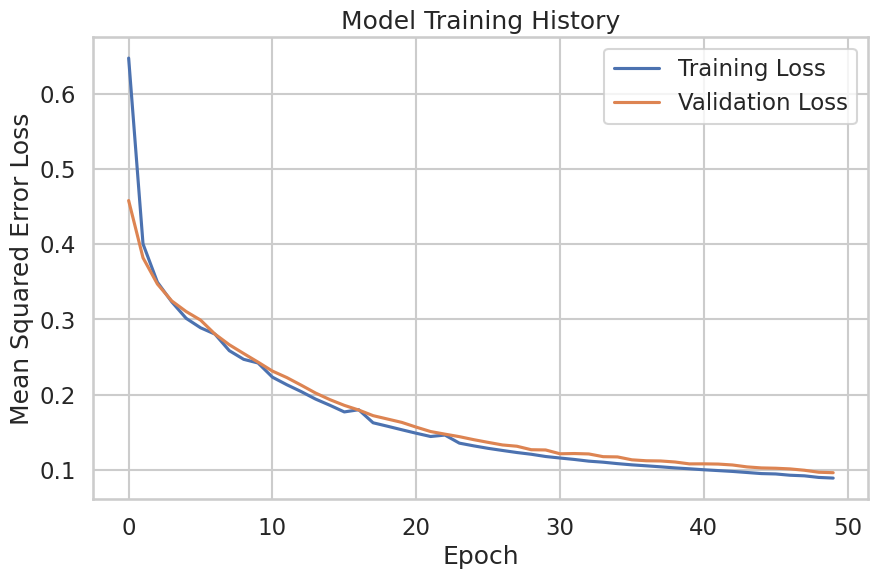


Pre-trained encoder saved to 'gaze_encoder_pretrained.h5'
This encoder is now ready for Phase 2: Fine-tuning!


In [ ]:
# Block 5: Plot Training History and Save the Encoder
# Purpose: Visualize the training process and save the final, pre-trained encoder model.

print("--- Block 5: Saving the Pre-trained Encoder ---")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_history.png')
print("Saved training history plot to 'training_history.png'")
plt.show()

# The most important step: save the pre-trained encoder part of the model
encoder.save('gaze_encoder_pretrained.h5')
print("\nPre-trained encoder saved to 'gaze_encoder_pretrained.h5'")
print("This encoder is now ready for Phase 2: Fine-tuning!")

# --- End of Block 5 ---

## 6. Evaluation and Saving

In [ ]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import mse, MeanSquaredError

print("--- Block 1: Loading Models and Data ---")

try:
    # Define custom objects dictionary to help Keras recognize the 'mse' function
    custom_objects = {
        'mse': mse,
        'MeanSquaredError': MeanSquaredError
    }

    # Load the models with custom objects
    autoencoder = load_model('/content/best_autoencoder.h5', custom_objects=custom_objects)
    encoder = load_model('/content/gaze_encoder_pretrained.h5', custom_objects=custom_objects)

    # Load the scaler
    with open('/content/scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    # Load the test data
    X_test = np.load('/content/X_test.npy')

    print("Successfully loaded all necessary assets.")
    print(f"Encoder input shape: {encoder.input_shape}")
    print(f"Encoder output shape: {encoder.output_shape}")
    print(f"Test data shape: {X_test.shape}")

except Exception as e:
    print(f"An error occurred loading the files. Make sure all files are present. Details: {e}")

# --- End of Block 1 ---
print("\n" + "="*50 + "\n")

In [ ]:
# Block 2: Qualitative Test - Visualizing Reconstruction
# Purpose: To see how well the model can reconstruct a masked sequence.

print("--- Block 2: Visualizing Reconstruction on a Test Sample ---")

# Take one sample sequence from the test set
sample_sequence = X_test[100] # Using the 101st sample

# Create a masked version of the sample
masked_sample = sample_sequence.copy()
seq_len, n_features = sample_sequence.shape
n_to_mask = int(np.ceil(seq_len * 0.20)) # Mask 20%
mask_indices = np.random.choice(seq_len, n_to_mask, replace=False)
masked_sample[mask_indices] = 0.0

# The model expects a batch, so we add a batch dimension
masked_sample_batch = np.expand_dims(masked_sample, axis=0)

# Get the model's reconstruction
reconstructed_sample_batch = autoencoder.predict(masked_sample_batch)
reconstructed_sample = reconstructed_sample_batch[0]

# --- Plotting the results ---
feature_names = ['Duration', 'X-Pos', 'Y-Pos', 'Sac Amplitude', 'Sac Velocity']
fig, axes = plt.subplots(n_features, 1, figsize=(15, 12), sharex=True)
fig.suptitle('Qualitative Reconstruction Test', fontsize=16)

for i in range(n_features):
    axes[i].plot(sample_sequence[:, i], label='Original', color='blue', marker='.', linestyle='--')
    axes[i].plot(reconstructed_sample[:, i], label='Reconstructed', color='red', marker='x')
    axes[i].set_ylabel(feature_names[i])
    # Highlight the masked areas
    for idx in mask_indices:
        axes[i].axvspan(idx - 0.5, idx + 0.5, color='gray', alpha=0.3, label='Masked' if idx==mask_indices[0] else "")

axes[-1].set_xlabel('Timestep (Fixation Number)')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('reconstruction_test.png')
print("Saved plot: reconstruction_test.png")
plt.show()

# --- End of Block 2 ---
print("\n" + "="*50 + "\n")